#### Problem
Let's suppose you have N buttons. Each time you press a button, you receive a random reward. Both buttons have a reward that is normally distributed (random each time you press it), but you don't know what the mean and variance of each button is. Obviously, you'd like to find the button with the largest mean and just keep pressing it. But like I said, you don't know what it is.

In [1]:
import numpy as np
import random 
from collections import defaultdict
import matplotlib.pyplot as plt

In [2]:
def get_reward(idx, mu_sigma_dict):
	mu, sigma = mu_sigma_dict[idx]
	return np.random.normal(mu, sigma)

def generate_data(num_buttons):
	mu_sigma_dict = defaultdict(tuple)
	for i in range(num_buttons):
		mean = random.uniform(0, 10)
		sigma = random.uniform(0, 2)
		mu_sigma_dict[i] = (mean, sigma)
	print("Distribution (unknown) : {} \n".format(mu_sigma_dict))
	return mu_sigma_dict

def dummy_data(num_buttons):
	mu_sigma_dict = defaultdict(tuple)
	mu_sigma_dict[0] = (3, 3)
	mu_sigma_dict[1] = (9, 2)
	print("Distribution (unknown) : {} \n".format(mu_sigma_dict))
	return mu_sigma_dict

def get_optimum_reward(mu_sigma_dict, trials):
	mean_list = [value[0] for value in mu_sigma_dict.values()]
	max_mean_idx = np.argmax(mean_list)
	# print("max mean idx = ", max_mean_idx)
	optimum_reward = np.sum([get_reward(max_mean_idx, mu_sigma_dict) for _ in range(trials)])

	return optimum_reward

### Naive Strategy

In [3]:
def naive_strategy(mu_sigma_dict, total_trials, m = 20):

    max_mean = 0
    max_idx = 0
    reward = 0
    num_buttons = len(mu_sigma_dict.keys())
    mean_loss = 0
    var_loss = 0
    
    # press each button m times to generate dummy data : 
    for idx in range(num_buttons):
        reward_list = [get_reward(idx, mu_sigma_dict) for _ in range(m)]

        mean_estimate = np.mean(reward_list)
        sd_estimate = np.std(reward_list)
        reward += np.sum(reward_list)

        if mean_estimate > max_mean:
            max_mean = mean_estimate
            max_idx = idx

        mean_loss += (mean_estimate - mu_sigma_dict[idx][0])**2
        var_loss += (sd_estimate - mu_sigma_dict[idx][1])**2

#         print("Estimated mean for button {} = {}".format(idx, mean_estimate))
#         print("Estimated standard deviation for button {} = {}\n".format(idx, sd_estimate))

    trials_remaining = total_trials - (m * num_buttons)
#     print("Reward so far = ", reward)
#     print("Trials remaining = ", trials_remaining)
    
    if trials_remaining > 0:
        reward += np.sum([get_reward(max_idx, mu_sigma_dict) for _ in range(trials_remaining)])
        

    return reward, mean_loss, var_loss

### Probabilistic Strategy

In [4]:
def probability_strategy(mu_sigma_dict, total_trials, m = 20):

    reward = 0
    num_buttons = len(mu_sigma_dict.keys())
    probability_list = []

    for idx in range(num_buttons):
        reward_list = [get_reward(idx, mu_sigma_dict) for _ in range(m)]
        reward += np.sum(reward_list)
        mean_reward = np.mean(reward_list)
        probability_list.append(mean_reward)

    normalised_probability_list = [float(x)/sum(probability_list) for x in probability_list]
    # print(normalised_probability_list)

    trials_remaining = total_trials - (m * num_buttons)
#     print("Reward so far = ", reward)
#     print("Trials remaining = ", trials_remaining)
    
    if trials_remaining > 0:
        try:
            buttons_pressed = np.random.choice(num_buttons, trials_remaining, p = normalised_probability_list)
        except:
            print("probability list = ", probability_list)
            
        for button_idx in buttons_pressed:
            reward += get_reward(button_idx, mu_sigma_dict)

    return reward

### $\epsilon$ - greedy

In [5]:
def epsilon_greedy(mu_sigma_dict, trials = 100, p = 0.8):
    reward = 0

    opt_b = 0
    opt_r = 0
    
    # Determine best button
    for key, val in mu_sigma_dict.items():
        r = get_reward(key, mu_sigma_dict)
        reward += r
        if r > opt_r:
            opt_r = r
            opt_b = key
        trials -= 1

    buttons = list(mu_sigma_dict.keys())
    
    for i in range(trials):
        if random.random() < p:
            r = get_reward(opt_b, mu_sigma_dict)
            reward += r
        else:
            b = np.random.choice(buttons)
            r = get_reward(b, mu_sigma_dict)
            if r > opt_r:
                opt_r = r
                opt_b = b

    return reward

In [6]:
def epsilon_greedy(mu_sigma_dict, total_trials, epsilon_time_variant = False, m = 20, epsilon = 0.2):
    
    reward = 0
    num_buttons = len(mu_sigma_dict.keys())
    reward_button_dic = defaultdict(tuple)

    for idx in range(num_buttons):
        reward_list = [get_reward(idx, mu_sigma_dict) for _ in range(m)]
        reward += np.sum(reward_list)
        sum_reward = np.sum(reward_list)
        reward_button_dic[idx] = (sum_reward, m)

    trials_remaining = total_trials - (m * num_buttons)
    buttons = list(mu_sigma_dict.keys())

    for t in range(trials_remaining):
        
        if epsilon_time_variant:
            epsilon = epsilon/(t+1)
            
        if random.random() < 1 - epsilon:
            idx = sorted(reward_button_dic.keys(), key = lambda x: reward_button_dic[x][0]/reward_button_dic[x][1], reverse = True)[0]
            r = get_reward(idx, mu_sigma_dict)
        else:
            idx = np.random.choice(buttons)
            r = get_reward(idx, mu_sigma_dict)

        reward += r
        
#         Add reward to button dictionary 
        current_sum, current_count = reward_button_dic[idx]
        reward_button_dic[idx] = (current_sum + r, current_count + 1)
    return reward

### Upper confidence bound policy (UCB)

In [7]:
# known variance
def ucb(mu_sigma_dict, total_trials, m = 20):
    
    reward = 0
    num_buttons = len(mu_sigma_dict.keys())
    reward_button_dic = defaultdict(tuple)

    for idx in range(num_buttons):
        reward_list = [get_reward(idx, mu_sigma_dict) for _ in range(m)]
        reward += np.sum(reward_list)
        sum_reward = np.sum(reward_list)
        reward_button_dic[idx] = (sum_reward, m)

    trials_remaining = total_trials - (m * num_buttons)
    buttons = list(mu_sigma_dict.keys())
    
    for t in range(trials_remaining):
        max_score = 0
        max_score_idx = 0
        for idx in buttons:
            sum_, count = reward_button_dic[idx]
            std_deviation = mu_sigma_dict[idx][1]
            score = (sum_/count) + std_deviation * np.sqrt(2 * np.log(t + 1) / count)
            if score > max_score:
                max_score = score
                max_score_idx = idx
#         press button with max score
        r = get_reward(max_score_idx, mu_sigma_dict)
        reward += r
#         Update dictionary
        current_sum, current_count = reward_button_dic[max_score_idx]
        reward_button_dic[max_score_idx] = (current_sum + r, current_count + 1)
    
    return reward

### UCB - Unknown variance

In [8]:
# known variance
def ucb_unknown_variance(mu_sigma_dict, total_trials, m = 20):
    
    reward = 0
    num_buttons = len(mu_sigma_dict.keys())
    reward_button_dic = defaultdict(tuple)

    for idx in range(num_buttons):
        reward_list = [get_reward(idx, mu_sigma_dict) for _ in range(m)]
        reward += np.sum(reward_list)
        sum_reward = np.sum(reward_list)
        reward_button_dic[idx] = (sum_reward, m, reward_list)

    trials_remaining = total_trials - (m * num_buttons)
    buttons = list(mu_sigma_dict.keys())

    for t in range(trials_remaining):
        max_score = 0
        max_score_idx = 0
        for idx in buttons:
            sum_, count, reward_list = reward_button_dic[idx]
            std_deviation = np.std(reward_list)
            score = (sum_/count) + std_deviation * np.sqrt(np.power(t + 1, 2 / (count - 2)) - 1)
            if score > max_score:
                max_score = score
                max_score_idx = idx
                
#         press button with max score
        r = get_reward(max_score_idx, mu_sigma_dict)
        reward += r
        
#         Update dictionary
        current_sum, current_count, current_reward_list = reward_button_dic[max_score_idx]
        current_reward_list.append(r)
        reward_button_dic[max_score_idx] = (current_sum + r, current_count + 1, current_reward_list)
    
    return reward

In [9]:
def compute_regret(mu_sigma_dict, num_list, strategy = 'naive'):
    
    regret_avg = []
    
    for trials in num_list:
        regret = []
        for _ in range(5):
            if strategy == 'naive':
                reward, _, _ = naive_strategy(mu_sigma_dict, trials)
            elif strategy == 'probability':
                reward = probability_strategy(mu_sigma_dict, total_trials = trials)
            elif strategy == 'epsilon-greedy':
                reward = epsilon_greedy(mu_sigma_dict, trials)
            elif strategy == 'epsilon-greedy-time-variant':
                reward = epsilon_greedy(mu_sigma_dict, trials, epsilon_time_variant = True)
            elif strategy == 'ucb':
                reward = ucb(mu_sigma_dict, trials)
            elif strategy == 'ucb-unknown-variance':
                reward = ucb_unknown_variance(mu_sigma_dict, trials)

            optimum_reward = get_optimum_reward(mu_sigma_dict, trials)
            regret.append(optimum_reward - reward)
        regret_avg.append(np.mean(regret))
#         print("Optimum reward = {}, reward = {}".format(optimum_reward, reward))
#     print("Regret = ", regret)

    return regret_avg 

In [10]:
def compute_avg_reward(mu_sigma_dict, num_list, strategy = 'naive'):
    
    avg_reward = []
    
    for trials in num_list:
        reward_list = []
        for _ in range(5):
            if strategy == 'naive':
                reward, _, _ = naive_strategy(mu_sigma_dict, trials)
            elif strategy == 'probability':
                reward = probability_strategy(mu_sigma_dict, total_trials = trials)
            elif strategy == 'epsilon-greedy':
                reward = epsilon_greedy(mu_sigma_dict, trials)
            elif strategy == 'epsilon-greedy-time-variant':
                reward = epsilon_greedy(mu_sigma_dict, trials, epsilon_time_variant = True)
            elif strategy == 'ucb':
                reward = ucb(mu_sigma_dict, trials)
            elif strategy == 'ucb-unknown-variance':
                reward = ucb_unknown_variance(mu_sigma_dict, trials)

            reward_list.append(reward/trials)
        avg_reward.append(np.mean(reward_list))
#         print("Optimum reward = {}, reward = {}".format(optimum_reward, reward))
#     print("Regret = ", regret)

    return avg_reward 

### Performance Evaluation

In [12]:
num_buttons = 5
mu_sigma_dict = generate_data(num_buttons)
# mu_sigma_dict = dummy_data(num_buttons)
trials = 1000
# Finding button with the largest mean
reward, mean_loss, sd_loss = naive_strategy(mu_sigma_dict, trials)
print("Mean loss = ", mean_loss)
print("Sd loss = ", sd_loss)

Distribution (unknown) : defaultdict(<class 'tuple'>, {0: (0.6637724586590654, 0.6287509865657184), 1: (0.6954931775571771, 0.5774434823425489), 2: (4.521173901604953, 1.05761391716073), 3: (3.838168023063684, 0.6027074216294506), 4: (9.32834165606636, 0.18045351355122907)}) 

Mean loss =  0.11936897175889981
Sd loss =  0.034666113518841885


In [9]:
num_buttons = 5
mu_sigma_dict = generate_data(num_buttons)

Distribution (unknown) : defaultdict(<class 'tuple'>, {0: (7.149439204111914, 0.5460655273994808), 1: (4.554444377383455, 0.7645904132263079), 2: (5.771501509113896, 1.0155307189586855), 3: (4.6984013674572624, 1.4061341974958486), 4: (3.7130347671631467, 1.1884987722078995)}) 



In [141]:
reward, _, _ = naive_strategy(mu_sigma_dict, total_trials = 1000, m = 20)
print("Reward = ", reward)
optimum_reward = get_optimum_reward(mu_sigma_dict, trials = 1000)
print("Optimum reward = ", optimum_reward)

Reward so far =  369.17496619412987
Trials remaining =  900
Reward =  5695.620315076174
Optimum reward =  5942.637728305364


In [142]:
reward = probability_strategy(mu_sigma_dict, total_trials = 1000, m = 20)
print("Reward = ", reward)
optimum_reward = get_optimum_reward(mu_sigma_dict, trials = 1000)
print("Optimum reward = ", optimum_reward)

Reward so far =  355.38076275242037
Trials remaining =  900
Reward =  4275.148949099481
Optimum reward =  5975.575262572649


In [59]:
reward = epsilon_greedy(mu_sigma_dict, total_trials = 200)
optimum_reward = get_optimum_reward(mu_sigma_dict, trials = 200)

print("Reward = ", reward)
print("Optimum reward = ", optimum_reward)

Reward =  1132.3200673265505
Optimum reward =  1229.8719994391372


In [56]:
reward = epsilon_greedy(mu_sigma_dict, total_trials = 200, epsilon_time_variant = True)
optimum_reward = get_optimum_reward(mu_sigma_dict, trials = 200)

print("Reward = ", reward)
print("Optimum reward = ", optimum_reward)

Reward =  1194.4354521890748
Optimum reward =  1228.6778722774675


In [74]:
num_buttons = 5
mu_sigma_dict = generate_data(num_buttons)
reward = ucb(mu_sigma_dict, total_trials = 200)
optimum_reward = get_optimum_reward(mu_sigma_dict, trials = 200)

print("Reward = ", reward)
print("Optimum reward = ", optimum_reward)

Distribution (unknown) : defaultdict(<class 'tuple'>, {0: (5.635472605513233, 1.853617247228329), 1: (4.942721944174849, 0.19136828118852622), 2: (0.6203398757442813, 0.6065608153625035), 3: (0.5697706303051819, 1.1182725978246804), 4: (6.7407785461169265, 1.8349515546403599)}) 

Reward =  1037.8820016742293
Optimum reward =  1391.4215755816044


In [129]:
num_buttons = 5
mu_sigma_dict = generate_data(num_buttons)
reward = ucb_unknown_variance(mu_sigma_dict, total_trials = 200)
optimum_reward = get_optimum_reward(mu_sigma_dict, trials = 200)

print("Reward = ", reward)
print("Optimum reward = ", optimum_reward)

Distribution (unknown) : defaultdict(<class 'tuple'>, {0: (7.121505882435805, 1.8192580209014884), 1: (1.6042462846160888, 1.1142186770935354), 2: (7.590611000508336, 1.1681632923552567), 3: (6.249224285350037, 0.7003813051584573), 4: (7.129652297045012, 0.8519141495973561)}) 

Reward =  1371.9832608017086
Optimum reward =  1537.5985902471743


Distribution (unknown) : defaultdict(<class 'tuple'>, {0: (8.37185142388448, 1.384694152701933), 1: (1.33097393779672, 1.7746471021971566), 2: (6.214677429281862, 1.2489597437945803), 3: (9.329528043739446, 0.41227784904318776), 4: (9.613525825083771, 0.6698022368162009)}) 



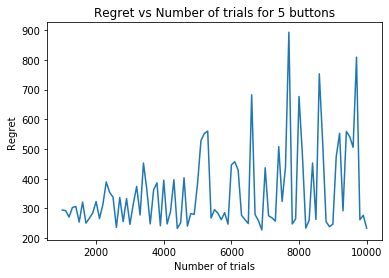

In [117]:
# Plot reward for naive strategy
num_buttons = 5
mu_sigma_dict = generate_data(num_buttons)
num_list = np.arange(1000, 10001, 100)
regret = compute_regret(mu_sigma_dict, num_list, strategy = 'naive')
plt.plot(num_list, regret, '-')
plt.xlabel("Number of trials")
plt.ylabel("Regret")
plt.title("Regret vs Number of trials for {} buttons".format(num_buttons))
plt.show()

Distribution (unknown) : defaultdict(<class 'tuple'>, {0: (7.078930071006832, 0.35317804648816087), 1: (4.326184394753021, 0.024477846443490714)}) 



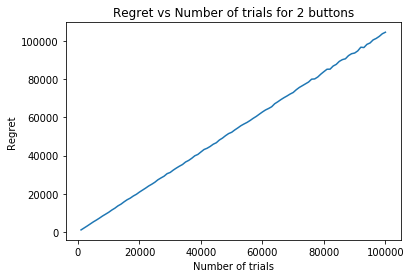

In [147]:
# Plot reward for probability strategy
num_buttons = 2
mu_sigma_dict = generate_data(num_buttons)
num_list = np.arange(1000, 100001, 1000)
regret = compute_regret(mu_sigma_dict, num_list, strategy = 'probability')
plt.plot(num_list, regret, '-')
plt.xlabel("Number of trials")
plt.ylabel("Regret")
plt.title("Regret vs Number of trials for {} buttons".format(num_buttons))
plt.show()

Distribution (unknown) : defaultdict(<class 'tuple'>, {0: (0.8022307052324507, 1.2106334247463943), 1: (2.5324920367085726, 1.1162394040439305)}) 



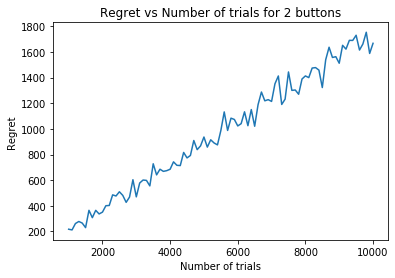

In [87]:
# Plot reward for epsilon greedy strategy
num_buttons = 2
mu_sigma_dict = generate_data(num_buttons)
num_list = np.arange(1000, 10001, 100)
regret = compute_regret(mu_sigma_dict, num_list, strategy = 'epsilon-greedy')
plt.plot(num_list, regret, '-')
plt.xlabel("Number of trials")
plt.ylabel("Regret")
plt.title("Regret vs Number of trials for {} buttons".format(num_buttons))
plt.show()

Distribution (unknown) : defaultdict(<class 'tuple'>, {0: (9.217108676843877, 1.5697497305005772), 1: (1.7934909170214874, 0.31095069051886703)}) 



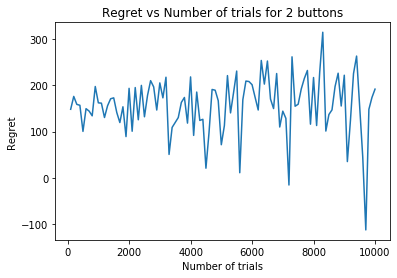

In [88]:
# Plot reward for epsilon greedy strategy
num_buttons = 2
mu_sigma_dict = generate_data(num_buttons)
num_list = np.arange(100, 10001, 100)
regret = compute_regret(mu_sigma_dict, num_list, strategy = 'epsilon-greedy-time-variant')
plt.plot(num_list, regret, '-')
plt.xlabel("Number of trials")
plt.ylabel("Regret")
plt.title("Regret vs Number of trials for {} buttons".format(num_buttons))
plt.show()

Distribution (unknown) : defaultdict(<class 'tuple'>, {0: (2.3068291336329017, 0.3726376685256467), 1: (2.704654606214297, 1.0711901769212642)}) 



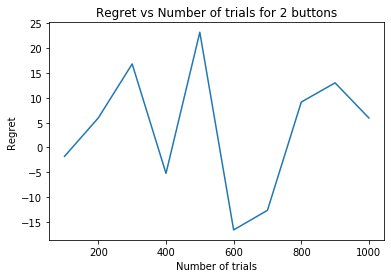

In [120]:
# Plot reward for ucb
num_buttons = 2
mu_sigma_dict = generate_data(num_buttons)
num_list = np.arange(100, 1001, 100)
regret = compute_regret(mu_sigma_dict, num_list, strategy = 'ucb-unknown-variance')
plt.plot(num_list, regret, '-')
plt.xlabel("Number of trials")
plt.ylabel("Regret")
plt.title("Regret vs Number of trials for {} buttons".format(num_buttons))
plt.show()

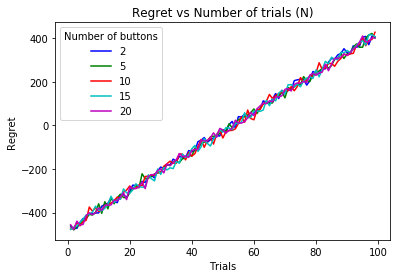

In [113]:
# plot num_buttons vs regret 
num_list = np.arange(1, 100, 1)
num_buttons_list = [2, 5, 10, 15, 20]

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
i = 0
for num_buttons in num_buttons_list:
	regret = compute_regret(mu_sigma_dict, num_list, strategy = 'naive')
	plt.plot(num_list, regret, color = colors[i])
	i += 1

plt.legend(num_buttons_list, title = "Number of buttons")
plt.xlabel("Trials")
plt.ylabel("Regret")
plt.title("Regret vs Number of trials (N)")
plt.show()

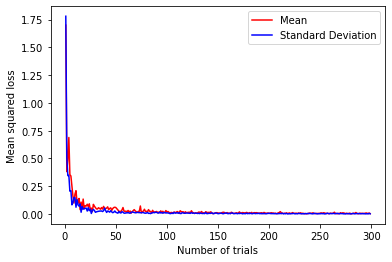

In [80]:
# Plot of mean variance loss vs num of trials
num_trials = np.arange(1, 300, 1)
mean_loss_list = []
sd_loss_list = []

for n in num_trials:
	mean_loss_avg = []
	sd_loss_avg = []
	for _ in range(10):
		_, mean_loss, sd_loss = naive_strategy(mu_sigma_dict, total_trials = n, m = n)	
		mean_loss_avg.append(mean_loss)
		sd_loss_avg.append(sd_loss)		
	mean_loss_list.append(np.mean(mean_loss_avg))
	sd_loss_list.append(np.mean(sd_loss_avg))

plt.plot(num_trials, mean_loss_list, '-r', label = "Mean")
plt.plot(num_trials, sd_loss_list, '-b', label = "Standard Deviation")
plt.xlabel("Number of trials")
plt.ylabel("Mean squared loss")
# plt.xticks(num_trials)
plt.legend()
plt.show()

In [131]:
num_trials_list = np.arange(1000, 10001, 100)
# num_trials_list = np.arange(100, 1100, 100)
num_buttons = 5
mu_sigma_dict = generate_data(num_buttons)
regret_probability = compute_regret(mu_sigma_dict, num_trials_list, strategy = 'probability')
regret_naive = compute_regret(mu_sigma_dict, num_trials_list, strategy = 'naive')
regret_epsilon_greedy = compute_regret(mu_sigma_dict, num_trials_list, strategy = 'epsilon-greedy')
regret_epsilon_greedy_time_variant = compute_regret(mu_sigma_dict, num_trials_list, strategy = 'epsilon-greedy-time-variant')
regret_epsilon_ucb = compute_regret(mu_sigma_dict, num_trials_list, strategy = 'ucb')
# regret_epsilon_ucb_unknown_variance = compute_regret(mu_sigma_dict, num_trials_list, strategy = 'ucb-unknown-variance')

Distribution (unknown) : defaultdict(<class 'tuple'>, {0: (7.078115440693721, 1.3944759293941138), 1: (9.622239935549091, 0.1577801126096965), 2: (4.7300600456234845, 1.9538066243997354), 3: (2.0969910916960712, 1.5267985068935002), 4: (7.703933300591036, 1.2533814023939835)}) 



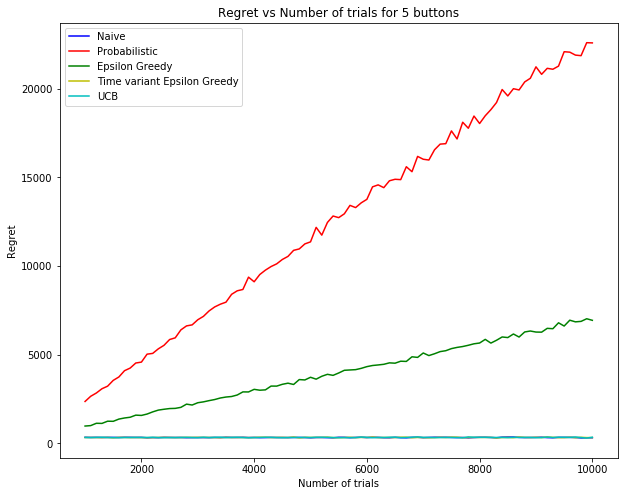

In [134]:
plt.figure(figsize = (10, 8))
plt.plot(num_trials_list, regret_naive, '-b', label = "Naive")
plt.plot(num_trials_list, regret_probability, '-r', label = "Probabilistic")
plt.plot(num_trials_list, regret_epsilon_greedy, '-g', label = "Epsilon Greedy")
plt.plot(num_trials_list, regret_epsilon_greedy_time_variant, '-y', label = "Time variant Epsilon Greedy")
plt.plot(num_trials_list, regret_epsilon_ucb, '-c', label = "UCB")
# plt.plot(num_trials_list, regret_epsilon_ucb_unknown_variance, '-c', label = "UCB unknown variance")
plt.xlabel("Number of trials")
plt.ylabel("Regret")
plt.legend()
plt.title("Regret vs Number of trials for {} buttons".format(num_buttons))
plt.show()

### Plotting average reward

In [38]:
mu_sigma_dict = generate_data(num_buttons = 5)

Distribution (unknown) : defaultdict(<class 'tuple'>, {0: (5.3249555904514265, 1.8675894533071233), 1: (7.645884320892211, 1.7816588301469778), 2: (6.629447434352905, 0.043404767815425904), 3: (7.561065399642838, 1.0255583399719186), 4: (8.235573442547224, 0.2880709012274709)}) 



In [11]:
trials = 1000
reward_naive,_,_ = naive_strategy(mu_sigma_dict, total_trials = 1000, m = 20)

In [39]:
avg_reward = []
trial_list = range(100, 1000)
for trials in trial_list:
    reward = probability_strategy(mu_sigma_dict, total_trials = trials, m = 20)
    avg_reward.append(reward/trials)

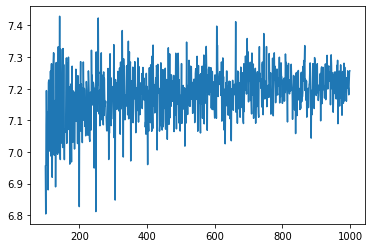

In [40]:
plt.plot(trial_list, avg_reward)

In [47]:
num_trials_list = np.arange(100, 10001, 1000)
# num_trials_list = np.arange(100, 1100, 100)
num_buttons = 5
mu_sigma_dict = generate_data(num_buttons)

Distribution (unknown) : defaultdict(<class 'tuple'>, {0: (3.143276063150232, 0.7627313785946135), 1: (2.973208114944711, 0.5879810623751534), 2: (2.625158762059537, 1.655676317391473), 3: (1.9074091896666945, 1.4642677177852816), 4: (5.697480119525244, 0.24955110817149873)}) 



In [48]:
avg_reward_probability = compute_avg_reward(mu_sigma_dict, num_trials_list, strategy = 'probability')
avg_reward_naive = compute_avg_reward(mu_sigma_dict, num_trials_list, strategy = 'naive')
avg_reward_epsilon_greedy = compute_avg_reward(mu_sigma_dict, num_trials_list, strategy = 'epsilon-greedy')
avg_reward_epsilon_greedy_time_variant = compute_avg_reward(mu_sigma_dict, num_trials_list, strategy = 'epsilon-greedy-time-variant')
avg_reward_epsilon_ucb = compute_avg_reward(mu_sigma_dict, num_trials_list, strategy = 'ucb')
# regret_epsilon_ucb_unknown_variance = compute_regret(mu_sigma_dict, num_trials_list, strategy = 'ucb-unknown-variance')

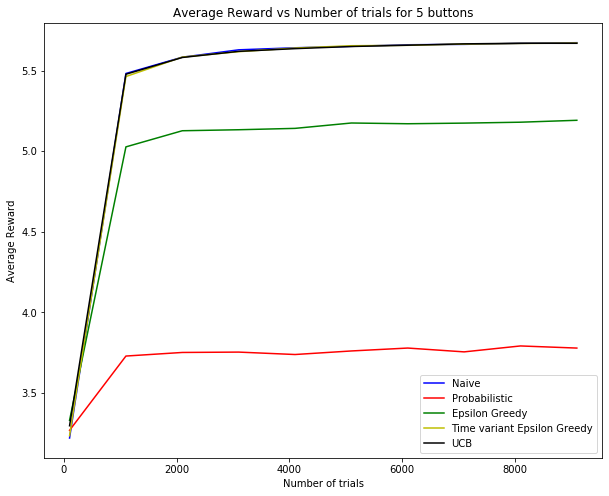

In [51]:
plt.figure(figsize = (10, 8))
plt.plot(num_trials_list, avg_reward_naive, '-b', label = "Naive")
plt.plot(num_trials_list, avg_reward_probability, '-r', label = "Probabilistic")
plt.plot(num_trials_list, avg_reward_epsilon_greedy, '-g', label = "Epsilon Greedy")
plt.plot(num_trials_list, avg_reward_epsilon_greedy_time_variant, '-y', label = "Time variant Epsilon Greedy")
plt.plot(num_trials_list, avg_reward_epsilon_ucb, '-k', label = "UCB")
# plt.plot(num_trials_list, regret_epsilon_ucb_unknown_variance, '-c', label = "UCB unknown variance")
plt.xlabel("Number of trials")
plt.ylabel("Average Reward")
plt.legend()
plt.title("Average Reward vs Number of trials for {} buttons".format(num_buttons))
plt.show()

### Modified regret computation approach

In [40]:
def naive_strategy_modified(mu_sigma_dict, total_trials, m = 20):

    max_mean = 0
    max_idx = 0
    reward = 0
    num_buttons = len(mu_sigma_dict.keys())
    
    cumulative_regret_list = []
    reward_list = []
    cumulative_regret = 0
    
    # press each button m times to generate dummy data : 
    for idx in range(num_buttons):
        temp_reward_list = [get_reward(idx, mu_sigma_dict) for _ in range(m)]

        mean_estimate = np.mean(temp_reward_list)
        sd_estimate = np.std(temp_reward_list)
        reward += np.sum(temp_reward_list)

        if mean_estimate > max_mean:
            max_mean = mean_estimate
            max_idx = idx
        
        for r in temp_reward_list:
            reward_list.append(r)
            optimum_reward = get_optimum_reward(mu_sigma_dict, trials = 1)
            cumulative_regret += optimum_reward - r
            cumulative_regret_list.append(cumulative_regret)

    trials_remaining = total_trials - (m * num_buttons)
    
    if trials_remaining > 0:
#         reward += np.sum([get_reward(max_idx, mu_sigma_dict) for _ in range(trials_remaining)])
        for _ in range(trials_remaining):
            r = get_reward(max_idx, mu_sigma_dict)
            reward_list.append(r)
            optimum_reward = get_optimum_reward(mu_sigma_dict, trials = 1)
            cumulative_regret += optimum_reward - r
            cumulative_regret_list.append(cumulative_regret)

    return reward, reward_list, cumulative_regret_list

In [79]:
def probability_strategy_modified(mu_sigma_dict, total_trials, m = 20):

    cumulative_regret_list = []
    cumulative_regret = 0
    cumulative_reward = 0
    reward_list = []
    num_buttons = len(mu_sigma_dict.keys())
    probability_list = []
    
    for idx in range(num_buttons):
        temp_reward_list = [get_reward(idx, mu_sigma_dict) for _ in range(m)]
        cumulative_reward += np.sum(temp_reward_list)
        mean_reward = np.mean(temp_reward_list)
        probability_list.append(mean_reward)
        
        for r in temp_reward_list:
            optimum_reward = get_optimum_reward(mu_sigma_dict, trials = 1)
            cumulative_regret += optimum_reward - r
            cumulative_regret_list.append(cumulative_regret)
            reward_list.append(r)

    normalised_probability_list = [float(x)/sum(probability_list) for x in probability_list]
    print(normalised_probability_list)

    trials_remaining = total_trials - (m * num_buttons)
#     print("Reward so far = ", reward)
#     print("Trials remaining = ", trials_remaining)
    
    if trials_remaining > 0:
        try:
            buttons_pressed = np.random.choice(num_buttons, trials_remaining, p = normalised_probability_list)
        except:
            print("probability list = ", probability_list)
            
        cnt = 0
        for button_idx in buttons_pressed:
            r = get_reward(button_idx, mu_sigma_dict)
            cumulative_reward += r
            optimum_reward = get_optimum_reward(mu_sigma_dict, trials = 1)
            cumulative_regret += optimum_reward - r
            cumulative_regret_list.append(cumulative_regret)
            reward_list.append(r)
            print("\nReward obtained = " , r)
            print("optimum reward = ", optimum_reward)
            print("cumulative regret = ", cumulative_regret)
            if cnt > 10:
                break
            cnt += 1

    return cumulative_reward, reward_list, cumulative_regret_list

In [85]:
num_buttons = 5
mu_sigma_dict = generate_data(num_buttons)

reward, reward_list, cumulative_regret_list = probability_strategy_modified(mu_sigma_dict, total_trials = 10000, m = 100)

Distribution (unknown) : defaultdict(<class 'tuple'>, {0: (9.730816795304303, 0.46789584733876244), 1: (7.66758851577297, 0.3649644570620343), 2: (0.12224494945530018, 0.5541836237640403), 3: (8.60988941763468, 0.7736791242516856), 4: (4.738508054394317, 0.9356604827476631)}) 

[0.3138368860523811, 0.24652554400958374, 0.0024193863089983637, 0.2825905587474559, 0.15462762488158083]

 Reward obtained =  9.185161132397017
optimum reward =  9.069385895817799
cumulative regret =  1783.1042263691857

 Reward obtained =  9.333171256773324
optimum reward =  9.536478936712392
cumulative regret =  1783.3075340491248

 Reward obtained =  9.897066196794771
optimum reward =  10.041731372654791
cumulative regret =  1783.4521992249847

 Reward obtained =  9.174242031479077
optimum reward =  9.841304223304371
cumulative regret =  1784.11926141681

 Reward obtained =  7.452193475369318
optimum reward =  10.11439934316204
cumulative regret =  1786.7814672846027

 Reward obtained =  10.040942146615953
o

In [81]:
avg_reward = []
prev_sum = 0
for t in range(10000):
    r = reward_list[t]
    prev_sum += r
    avg_reward.append(prev_sum/(t+1))

IndexError: list index out of range

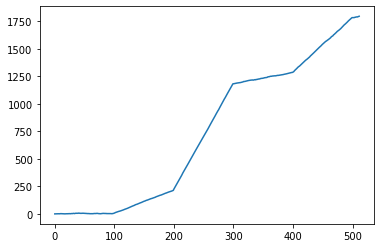

In [86]:
plt.plot(cumulative_regret_list)

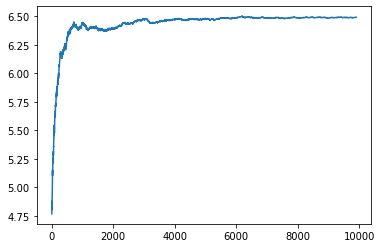

In [38]:
plt.plot(avg_reward[100:])

In [41]:
num_buttons = 5
mu_sigma_dict = generate_data(num_buttons)

reward, reward_list, cumulative_regret_list = naive_strategy_modified(mu_sigma_dict, total_trials = 10000, m = 20)

Distribution (unknown) : defaultdict(<class 'tuple'>, {0: (5.762542605624635, 0.9536842264692384), 1: (4.186918467606397, 1.2449523306266457), 2: (1.5212976223382313, 0.5660207353425197), 3: (4.568726969278015, 1.4279656499138027), 4: (5.906124079872896, 0.7161849103779079)}) 



In [42]:
avg_reward = []
prev_sum = 0
for t in range(10000):
    r = reward_list[t]
    prev_sum += r
    avg_reward.append(prev_sum/(t+1))

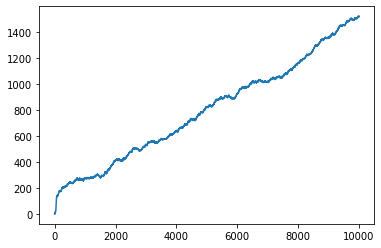

In [43]:
plt.plot(cumulative_regret_list)

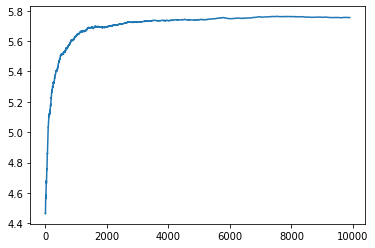

In [44]:
plt.plot(avg_reward[100:])

In [72]:
## Comparison
num_buttons = 5
mu_sigma_dict = generate_data(num_buttons)

naive_reward_list, naive_reward_list, naive_cumulative_regret_list = naive_strategy_modified(mu_sigma_dict, total_trials = 10000, m = 20)
prob_reward_list, prob_reward_list, prob_cumulative_regret_list = probability_strategy_modified(mu_sigma_dict, total_trials = 10000, m = 20)


Distribution (unknown) : defaultdict(<class 'tuple'>, {0: (5.580878603695404, 0.20558939346574023), 1: (6.965898592976352, 1.1597533667941031), 2: (5.251661241151102, 0.8121401677873645), 3: (4.408110412185322, 1.9791840500325872), 4: (2.106008164584734, 0.7960033583281774)}) 



In [47]:
def get_avg_reward_list(reward_list):
    avg_reward = []
    prev_sum = 0
    tmax = len(reward_list)
    for t in range(tmax):
        r = reward_list[t]
        prev_sum += r
        avg_reward.append(prev_sum/(t+1))
    return avg_reward

In [68]:
naive_avg_reward_list = get_avg_reward_list(naive_reward_list)
prob_avg_reward_list = get_avg_reward_list(prob_reward_list)

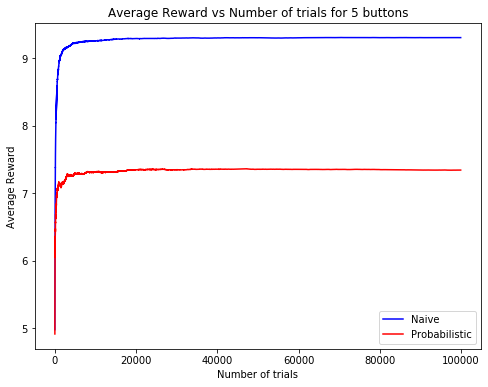

In [69]:
plt.figure(figsize = (8, 6))
plt.plot(naive_avg_reward_list[100:], '-b', label = "Naive")
plt.plot(prob_avg_reward_list[100:], '-r', label = "Probabilistic")
plt.xlabel("Number of trials")
plt.ylabel("Average Reward")
plt.legend()
plt.title("Average Reward vs Number of trials for {} buttons".format(num_buttons))
plt.show()

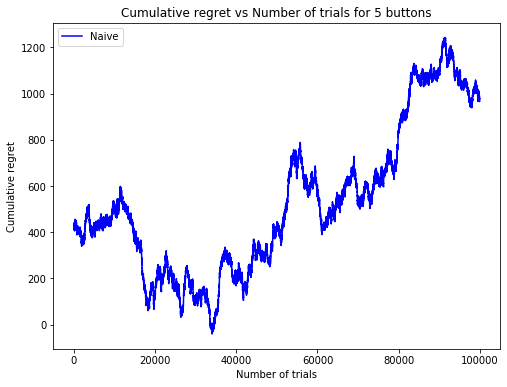

In [70]:
plt.figure(figsize = (8, 6))
plt.plot(naive_cumulative_regret_list[100:], '-b', label = "Naive")
# plt.plot(prob_cumulative_regret_list[100:], '-r', label = "Probabilistic")
plt.xlabel("Number of trials")
plt.ylabel("Cumulative regret")
plt.legend()
plt.title("Cumulative regret vs Number of trials for {} buttons".format(num_buttons))
plt.show()

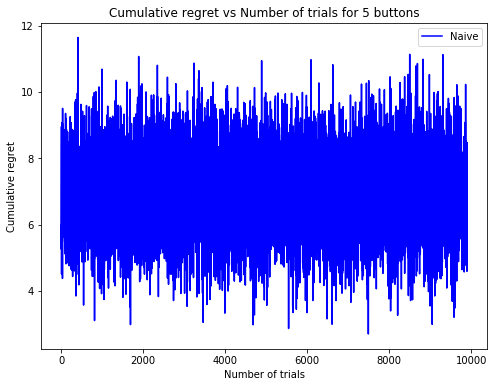

In [73]:
plt.figure(figsize = (8, 6))
plt.plot(naive_reward_list[100:], '-b', label = "Naive")
# plt.plot(prob_cumulative_regret_list[100:], '-r', label = "Probabilistic")
plt.xlabel("Number of trials")
plt.ylabel("Cumulative regret")
plt.legend()
plt.title("Cumulative regret vs Number of trials for {} buttons".format(num_buttons))
plt.show()